<a href="https://colab.research.google.com/github/BenYavor/MA_GAN/blob/master/Changed_MA_GAN_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.0.0
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import os
tf.__version__
from tensorflow import keras
import time
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd


###Systemparameter
$k$ - die Anzhal der bits \\
$M$ - Anzahl der unterschiedlichen Nachrichten \\
$n$ - channel uses\\
$N$ - Länge des Rauschvektors

In [0]:
k = 2      # Number of information bits per message, i.e., M=2**k
M = 2**k
n = 2     # Number of real channel uses per message
seed = 2    # Seed RNG reproduce identical results
D_nb_weights = 32
G_nb_weights = 32


batch_size = 100

x = tf.random.normal((batch_size,n))    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )


## Generator Model

In [0]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

#numpy version of kl divergence
def kl_divergence_np(p, q):
    #use "Laplace correction" w to avoid zero and inf
    w=1e-5
    p = p + w
    q = q + w
    return np.sum(p * np.log(p / q))

#tensorflow version of kl divergence
def kl_divergence_tf(p, q):
    #use "Laplace correction" w to avoid zero and inf
    w = 1e-5
    p = p + w
    q = q + w
    return tf.reduce_sum(p * tf.log(p / q))
  
  
  
train_SNR_dB = 7
noise_std = EbNo2Sigma(train_SNR_dB)

# Generator model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(2,)]               0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [()]                 0           tf_op_layer_Shape[0][0]          
__________________________________________________________________________________________________
tf_op_layer_random_normal/shape [(2,)]               0           tf_op_layer_strided_slice[0][0]  
______________________________________________________________________________________________

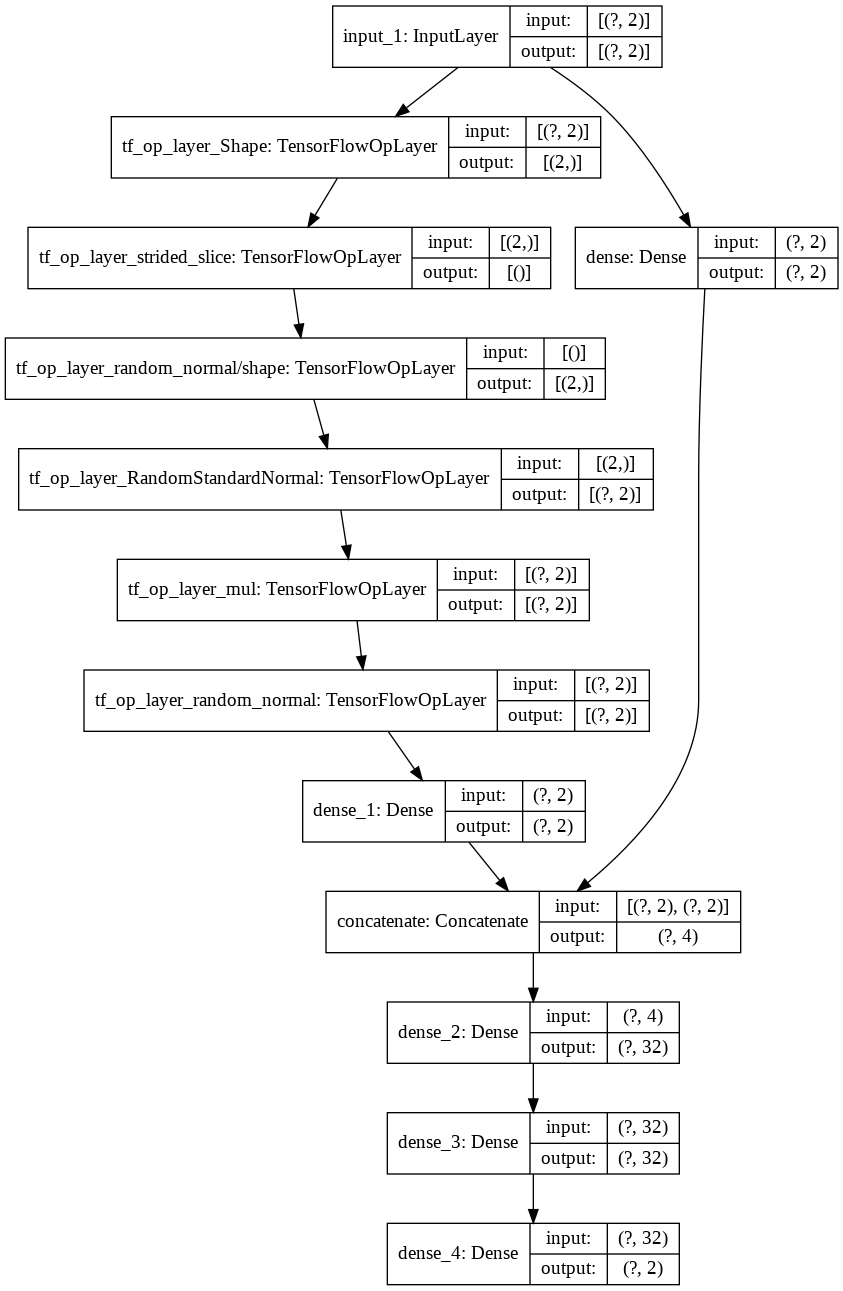

In [0]:
input1 = tf.keras.layers.Input(shape=(n,))
x1 = tf.keras.layers.Dense(n)(input1)
input2 =tf.random.normal([tf.shape(input1)[0],n])
x2 = tf.keras.layers.Dense(n)(input2)
subtracted = tf.keras.layers.Concatenate(1)([x1, x2])
h1 = tf.keras.layers.Dense(32,use_bias=True,  activation='relu')(subtracted)
h2 = tf.keras.layers.Dense(32,use_bias=True, activation='relu')(h1)
out = tf.keras.layers.Dense(n, use_bias= True, activation='linear')(h2)

generator = tf.keras.models.Model(inputs=[input1], outputs=out)
generator.summary()

tf.print(generator([x]).shape)


keras.utils.plot_model(generator, 'Structure_of_MI_estimation.png', show_shapes=True)

## Channels as Black-Box

In [0]:


def real_channel(x):
    # Black-box Channel
    #AWGN
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)

    #Rayleigh
    #return x + tf.sqrt(tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    
    #Uniform U(-3;3)    
    #return x + tf.random_uniform(tf.shape(x), minval=-2, maxval=2)

    


## Discriminator
Model definition and creating discriminator


In [0]:
randN_initial = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)


In [0]:
def get_discriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial,activation='relu',input_shape=((2*n,))))
  #model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial, activation='relu'))
  model.add(tf.keras.layers.Dense(1,use_bias=False, activation='sigmoid'))
  return model

discriminator = get_discriminator()
discriminator.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 32        
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


## Data Generation, überhaupt noch relevant??!!

## discriminator desicion????


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## defining Loss. TODO:
compile the Model with the right loss functions

In [0]:
x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
real_training_data = tf.concat(values=[real_channel(x), x], axis=-1)  
fake_training_data = tf.concat(values=[generator([x]),x], axis=-1)# training =True),x], axis=-1)

tf.print(real_training_data.shape,fake_training_data.shape)
real_output = discriminator(real_training_data)
fake_output = discriminator(fake_training_data)
tf.print(fake_output)
tf.print(real_output)
#print(real_output, fake_output)

TensorShape([100, 4]) TensorShape([100, 4])
[[0.505492389]
 [0.502738774]
 [0.511309326]
 ...
 [0.506559253]
 [0.497000605]
 [0.506654263]]
[[0.496904612]
 [0.494730145]
 [0.504692137]
 ...
 [0.517043531]
 [0.498621]
 [0.492711067]]


In [0]:
#def discriminator_loss(real_output, fake_output):
  #loss= -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
#  loss = tf.reduce_mean(real_output) - tf.reduce_mean(fake_output)  #Wasserstein GAN
#  return loss

def generator_loss(fake_output, generator):
  return -tf.reduce_mean(fake_output)


# Learning Rate

In [0]:
disc_loss = tf.reduce_mean(real_output) - tf.reduce_mean(fake_output)   #use "-" sign to minimize rather than maximize loss
gen_loss =  -tf.reduce_mean(fake_output)
#disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output)) #-tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
#gen_loss =-tf.reduce_mean(tf.math.log(fake_output))

tf.print(disc_loss, gen_loss)

generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)      #RMSprop   in oreder to test where the error comes from
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)      #

-0.0023188293 -0.491516709


# Evaluation with Histogram

In [0]:
def generate_evaluation_data(batch_size=100):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )
  #G_n = tf.random.normal([tf.shape(x)[0],n],dtype=tf.float32) 
  #inputs = tf.concat(values=[x, G_n], axis=1)
  fake_eval_data = tf.concat(values=[generator([x]), x], axis=1)
  real_eval_data = tf.concat(values=[real_channel(x), x], axis=1) #tf.concat(values=[real_channel(x),x], axis=1)
  inputs = x
  return  real_eval_data, fake_eval_data, inputs 



def get_evaluation_data(evaluation_per_epochs):
  real_eval_data = []
  fake_eval_data  = []
  inputs = []
  for i in range(evaluation_per_epochs):
    data = generate_evaluation_data()
    real_eval_data.append(data[0])
    fake_eval_data.append(data[1])
    inputs.append(data[2])
  return real_eval_data, fake_eval_data, inputs


def test_eval(real_eval_data,fake_eval_data,inputs):
  hist_range = 3
  

  
  fake_output_hist = np.mean(fake_eval_data,axis=0)  # Changed from 0 to 1
  real_output_hist = np.mean(real_eval_data,axis=0)
  inputs_hist = np.mean(inputs,axis=0)
    
  fake_output_hist1 = np.reshape( fake_output_hist,[-1,])
  real_output_hist1 = np.reshape( real_output_hist,[-1,])
    
  plt.hist(fake_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')
  plt.hist(real_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')    
  plt.title("noise distribution")
  plt.legend(["generator", "target"])
  plt.show()
  tf.print(inputs_hist.shape)
  
  

### Define the training loop

In [0]:
epochs = 5000
batch_size = 100

evaluation_per_epochs = 10

seed = tf.random.normal([batch_size, n])



In [0]:
def train(epochs, batch_size):
  start = time.time()
  counter = 0
  epoch = 0
  for epoch in range(epochs):
    counter += 1
    train_step()
    if counter%100==0:
      tf.print("counter %d:" % (counter))
      fake_c = generator(x)
      tf.print(fake_c[0])
    if counter%1000 == 0:
      real_c = real_channel(x)
      fake_c = generator(x)
      real_eval_data, fake_eval_data, inputs = get_evaluation_data(evaluation_per_epochs)
      test_eval(real_eval_data, fake_eval_data, inputs)
      tf.print(disc_loss, gen_loss)
    #print ('Time for epoch {} is {} sec,'.format(epoch + 1, time.time()-start))
      tf.print ('Time for epoch {},'.format(epoch + 1))
      
  tf.saved_model.save(generator,'/tmp/saved_model/')
  tf.print ('Time for the training is {} sec,'.format( time.time()-start))
    

## Training
strongly inspiered by: \\
https://www.tensorflow.org/beta/tutorials/generative/dcgan?hl=en

In [0]:
@tf.function
def train_step(): #epoch, steps_per_epoches , batch_size, generator, discriminator):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  for i in range(5):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      real_training_data = tf.concat(values=[real_channel(x), x], axis=1)
      fake_training_data = tf.concat(values=[generator(x),x], axis=1)# training =True),x], axis=1)
      real_output = discriminator(real_training_data)#, training=True)
      fake_output = discriminator(fake_training_data)
      
      
      disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))
      gen_loss =-tf.reduce_mean(tf.math.log(fake_output))
      
      #tf.print(disc_loss,gen_loss)
      
      if tf.math.is_nan(disc_loss) == False:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
      if i == 4:  
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))



## Train the model

counter 100:
[0.152003214 0.198672339]
counter 200:
[-0.411723435 0.0756245852]
counter 300:
[-0.337529629 0.17095685]
counter 400:
[0.730077326 -0.183587611]
counter 500:
[-0.376288712 0.661632419]
counter 600:
[-0.0853015259 0.480069846]
counter 700:
[-0.0501354076 0.235052228]
counter 800:
[-0.104366586 0.184163913]
counter 900:
[-0.13428849 0.423473507]
counter 1000:
[-0.281911939 0.520193934]


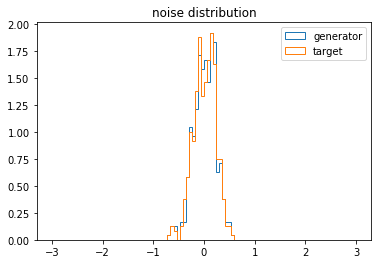

(100, 2)
-0.0023188293 -0.491516709
Time for epoch 1000,
counter 1100:
[-0.328920126 0.481549472]
counter 1200:
[-0.467465818 0.541726589]
counter 1300:
[-0.630983949 0.457063556]
counter 1400:
[-0.863789558 0.0274237487]
counter 1500:
[-0.0205760486 0.669306278]
counter 1600:
[-0.154396474 0.591409266]
counter 1700:
[-0.348959148 0.434527367]
counter 1800:
[-0.388418287 0.250410825]
counter 1900:
[-0.373008788 0.262140572]
counter 2000:
[-0.106425822 0.490141064]


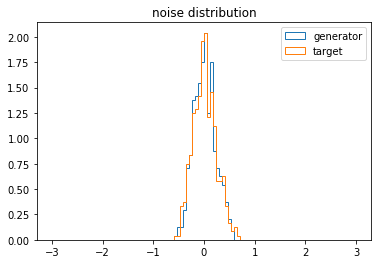

(100, 2)
-0.0023188293 -0.491516709
Time for epoch 2000,
counter 2100:
[-0.134468645 0.511813521]
counter 2200:
[-0.267464638 0.475349039]
counter 2300:
[-0.401705712 0.248135746]
counter 2400:
[-0.44948554 0.154253945]
counter 2500:
[-0.177702039 0.64531678]
counter 2600:
[-0.0639784113 0.538612247]
counter 2700:
[-0.26350823 0.237822086]
counter 2800:
[-0.0990225673 0.238342196]
counter 2900:
[-0.238598973 -0.351848066]
counter 3000:
[-0.447223127 0.269382656]


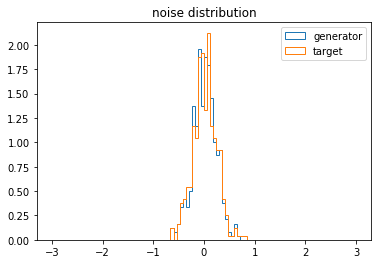

(100, 2)
-0.0023188293 -0.491516709
Time for epoch 3000,
counter 3100:
[-0.183338717 0.496916115]
counter 3200:
[-0.10581065 0.0930205435]
counter 3300:
[-0.253374279 0.578272104]
counter 3400:
[-0.59443897 0.0266770497]
counter 3500:
[0.0106787113 0.49824506]
counter 3600:
[-0.268432468 0.589163721]
counter 3700:
[-0.144683197 0.382613599]
counter 3800:
[-0.167273119 0.00266351551]
counter 3900:
[0.115657315 -0.123711944]
counter 4000:
[-0.0837523192 0.405266076]


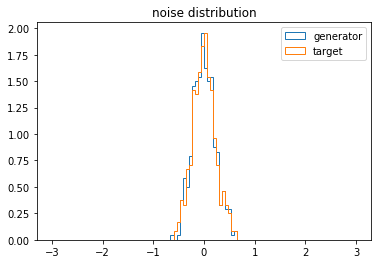

(100, 2)
-0.0023188293 -0.491516709
Time for epoch 4000,
counter 4100:
[-0.333686709 0.56907618]
counter 4200:
[-0.19885546 0.434521288]
counter 4300:
[0.0369473323 0.404878587]
counter 4400:
[0.367146 0.394162118]
counter 4500:
[-0.177210942 0.535202444]
counter 4600:
[-0.335326165 0.186884329]
counter 4700:
[-0.0929066762 0.481627852]
counter 4800:
[-0.262654841 0.613661945]
counter 4900:
[0.0149966562 -0.0383590311]
counter 5000:
[-0.290425211 0.644269407]


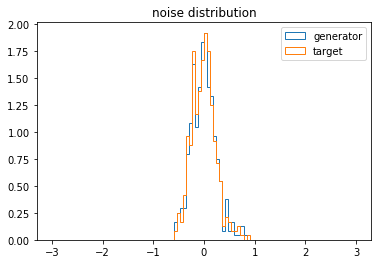

(100, 2)
-0.0023188293 -0.491516709
Time for epoch 5000,
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/saved_model/assets
Time for the training is 24.40695881843567 sec,
tf.Tensor([-0.07961416  0.49148208], shape=(2,), dtype=float32)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(2,)]               0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [()]                 0           tf_op_layer_Shape

In [0]:
%%time
train(epochs , batch_size)
print(generator(x)[1])
generator.summary()
discriminator.summary()



### Setting Generator as not trainable before training AE

In [0]:
generator.trainable = False
generator.summary()
tf.print(generator.trainable)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(2,)]               0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [()]                 0           tf_op_layer_Shape[0][0]          
__________________________________________________________________________________________________
tf_op_layer_random_normal/shape [(2,)]               0           tf_op_layer_strided_slice[0][0]  
______________________________________________________________________________________________

## AE
Die Idee sollte sein das Training auf den encoder und decoder einzuschränken. Jedoch soll **end-to-end** trainiert werden, hierfür sollte vllt eine art Funktion eingesetzt werden, welche über die GAN's Layer zurück geht.
Muss ich hierfür die Layer nochmals einzeln definieren?


***Vermutung: Der Ausgang hat die 8fache dimension des Eingangs-> daher nur 1/8 richtig oder 7/8 richtig*** \\
**zu klären: was passiert in meinem AE dass sie dei dimension ver8-facht von (1000,8) zu (8000,n)**
**Kontrollieren was der output von meinem GAN ist**
**Add complexity for higher rubustness**




In [0]:
def B_Ber(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def generate_data_vector(length):
  random_vector = tf.random.uniform(shape =(length,),minval=0,maxval=M, dtype=tf.dtypes.int32 ,seed=None,name=None)
  random_hot_one_vector = tf.one_hot(random_vector, depth=M,on_value=1, off_value=0,axis=-1)
  tf.print(random_hot_one_vector.shape)
  return random_hot_one_vector


EncIn = tf.keras.layers.Input(shape=(M,))#, dtype= tf.int32)
e1 = tf.keras.layers.Dense(n, activation=None)
e2 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
EncOut = tf.keras.layers.Lambda(lambda x: x/tf.sqrt(2*tf.reduce_mean(tf.square(x))))
GenIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x,(tf.shape(x)[0],-1)))
GenOut = tf.keras.layers.Lambda(generator)
DecIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
d1 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,n]))
d2 = tf.keras.layers.Dense(M, activation='relu')
DecOut = tf.keras.layers.Dense(M, activation='softmax')


encoder =tf.keras.models.Sequential([EncIn,e1,e2,EncOut,GenIn]) 
decoder =tf.keras.models.Sequential([DecIn,d1,d2,DecOut])

AE = tf.keras.models.Sequential([encoder,generator,decoder])

def generate_data_vector(length):
  random_vector = tf.random.uniform(shape =(length,),minval=0,maxval=M, dtype=tf.dtypes.int32 ,seed=None,name=None)
  random_hot_one_vector = tf.one_hot(random_vector, depth=M,on_value=1, off_value=0,axis=-1)
  tf.print(random_hot_one_vector.shape)
  return random_hot_one_vector

data, test_data = generate_data_vector(10000000), generate_data_vector(10000)

AE.compile(optimizer='nadam',loss='categorical_crossentropy',metrics=[B_Ber])
history = AE.fit(data, data, batch_size=500,steps_per_epoch=300, epochs=10)

AE.summary()  

TensorShape([10000000, 4])
TensorShape([10000, 4])
Train on 10000000 samples
Epoch 1/10
  145500/10000000 [..............................] - ETA: 59s - loss: 0.0364 - B_Ber: 5.0172e-04Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, None)              10        
_________________________________________________________________
model (Model)                (None, 2)                 1294      
_________________________________________________________________
sequential_2 (Sequential)    multiple                  32        
Total params: 1,336
Trainable params: 42
Non-trainable params: 1,294
_________________________________________________________________


In [0]:


def analytic_channel(input): 
  #print(input.shape)
  return input + tf.random.normal(tf.shape(input), mean=0.0, stddev=noise_std)

def real_transmision(test_data):
  y = encoder(test_data)
  y = generator(y)
  y = decoder(y)
  return y


def test_diff_eval(test_data, results):
  diff = []
  for i in range(tf.shape(test_data)[0]):
    diff.append(tf.math.subtract(test_data[i,:], results[i,:]))
  return diff
    
  
real_AE = real_transmision(test_data)
testTest = tf.dtypes.cast(real_AE + tf.constant(0.2,dtype=tf.float32,shape=tf.shape(real_AE)), tf.int32)

diff_test =  test_diff_eval(test_data, testTest) 





In [0]:
tf.print(sum(diff_test))

[22 0 0 0]


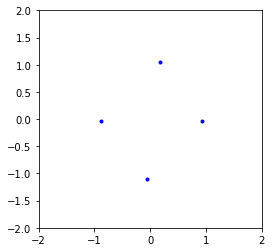

In [0]:
tes_data = np.eye(M, dtype = int)
coding= encoder.predict(tes_data)
fig = plt.figure(figsize=(4,4))
plt.plot(coding[:,0], coding[:,1],"b.")
plt.gca().set_ylim(-2,2)
plt.gca().set_xlim(-2,2)
plt.show()

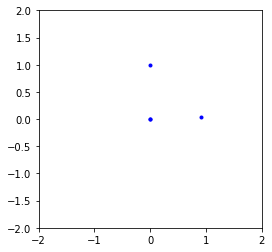

In [0]:
tes_data = np.eye(M, dtype = int)
coding= AE.predict(tes_data)
fig = plt.figure(figsize=(4,4))
plt.plot(coding[:,0], coding[:,1],"b.")
plt.gca().set_ylim(-2,2)
plt.gca().set_xlim(-2,2)
plt.show()

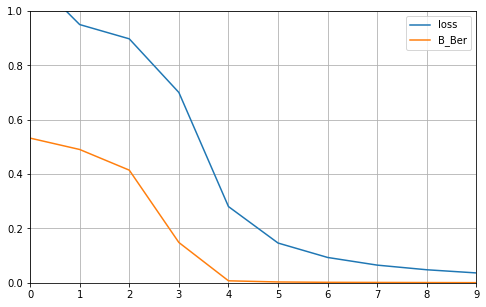

In [0]:
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()